# Electrical Conductance and Seebeck

In [1]:
import numpy as np

In [2]:
"""1/beta, x1, x2, zT, GS^2, S"""
data_opt = np.loadtxt('const_dom.csv',delimiter=',')
opt_G = data_opt[:,4] / (data_opt[:,5]**2)
opt_width = (data_opt[:,2] - data_opt[:,1])[..., np.newaxis]
beta_list = (1/data_opt[:,0])[..., np.newaxis]

In [3]:
opt_coeff = np.stack([opt_G, data_opt[:, 5], data_opt[:,3]], axis=1)

In [4]:
from equation import sigma_seebeck_zT

## Shift up

In [5]:
def solve_shift_up():
    x_shift_up = data_opt[:, 1:3] + opt_width/2
    data_shift_up = []
    for x1, x2, beta in np.hstack([x_shift_up, beta_list]):
        data_shift_up.append(sigma_seebeck_zT(x1, x2, beta))
    return np.vstack(data_shift_up)
data_shift_up = solve_shift_up()

e:\Users\Admin\GitProjects\OptimizeTransmission\linear\equation.py:142: RuntimeWarning: invalid value encountered in true_divide
  np.divide(i1, i0),
e:\Users\Admin\GitProjects\OptimizeTransmission\linear\equation.py:143: RuntimeWarning: invalid value encountered in true_divide
  np.divide(i12, ((I(x1,x2,2,dom)+beta)*i0-i12))


## Shift down

In [6]:
def solve_shift_down():
    x_shift_down = data_opt[:, 1:3] - opt_width/2
    data_shift_down = []
    for x1, x2, beta in np.hstack([x_shift_down, beta_list]):
        data_shift_down.append(sigma_seebeck_zT(x1, x2, beta))
    return np.vstack(data_shift_down)
data_shift_down = solve_shift_down()

## Broaden

In [7]:
def solve_broaden():
    x_broaden = data_opt[:, 1:3] + opt_width/2 * np.array([-1,1])
    data_broaden = []
    for x1, x2, beta in np.hstack([x_broaden, beta_list]):
        data_broaden.append(sigma_seebeck_zT(x1, x2, beta))
    return np.vstack(data_broaden)
data_broaden = solve_broaden()

## Narrow

In [8]:
def solve_narrow():
    x_narrow = data_opt[:, 1:3] + opt_width/4 * np.array([1,-1])
    data_narrow = []
    for x1, x2, beta in np.hstack([x_narrow, beta_list]):
        data_narrow.append(sigma_seebeck_zT(x1, x2, beta))
    return np.vstack(data_narrow)
data_narrow = solve_narrow()

## Trapezoid

In [31]:
from dom import trapezoid as trapezoid_dom

def solve_trapezoid():
    x_support = data_opt[:, 1:3] + opt_width * np.array([-1,1])
    data_trapezoid = []
    for x1, x2, x1_support, x2_support, beta in np.hstack([data_opt[:, 1:3], x_support, beta_list]):
        data_trapezoid.append(sigma_seebeck_zT(
            x1_support, x2_support, beta,
            lambda x: trapezoid_dom(x, x1, x2)
        ))
    return np.vstack(data_trapezoid)
data_trapezoid = solve_trapezoid()

In [10]:
data_trapezoid.shape

(301, 3)

## Plot

In [9]:
from plot import multi_plot, single_plot

In [10]:
def plot_coeff(data_list, label_list, line_style_list=[], coeff_type=2, axes=None):
    y_list = [ data[:, coeff_type] for data in data_list]
    axes = multi_plot(data_opt[:,0], y_list, label_list, line_style_list, axes)
    return axes

In [11]:
import matplotlib.pyplot as plt
from dom import boxcar as boxcar_dom

### plot shift

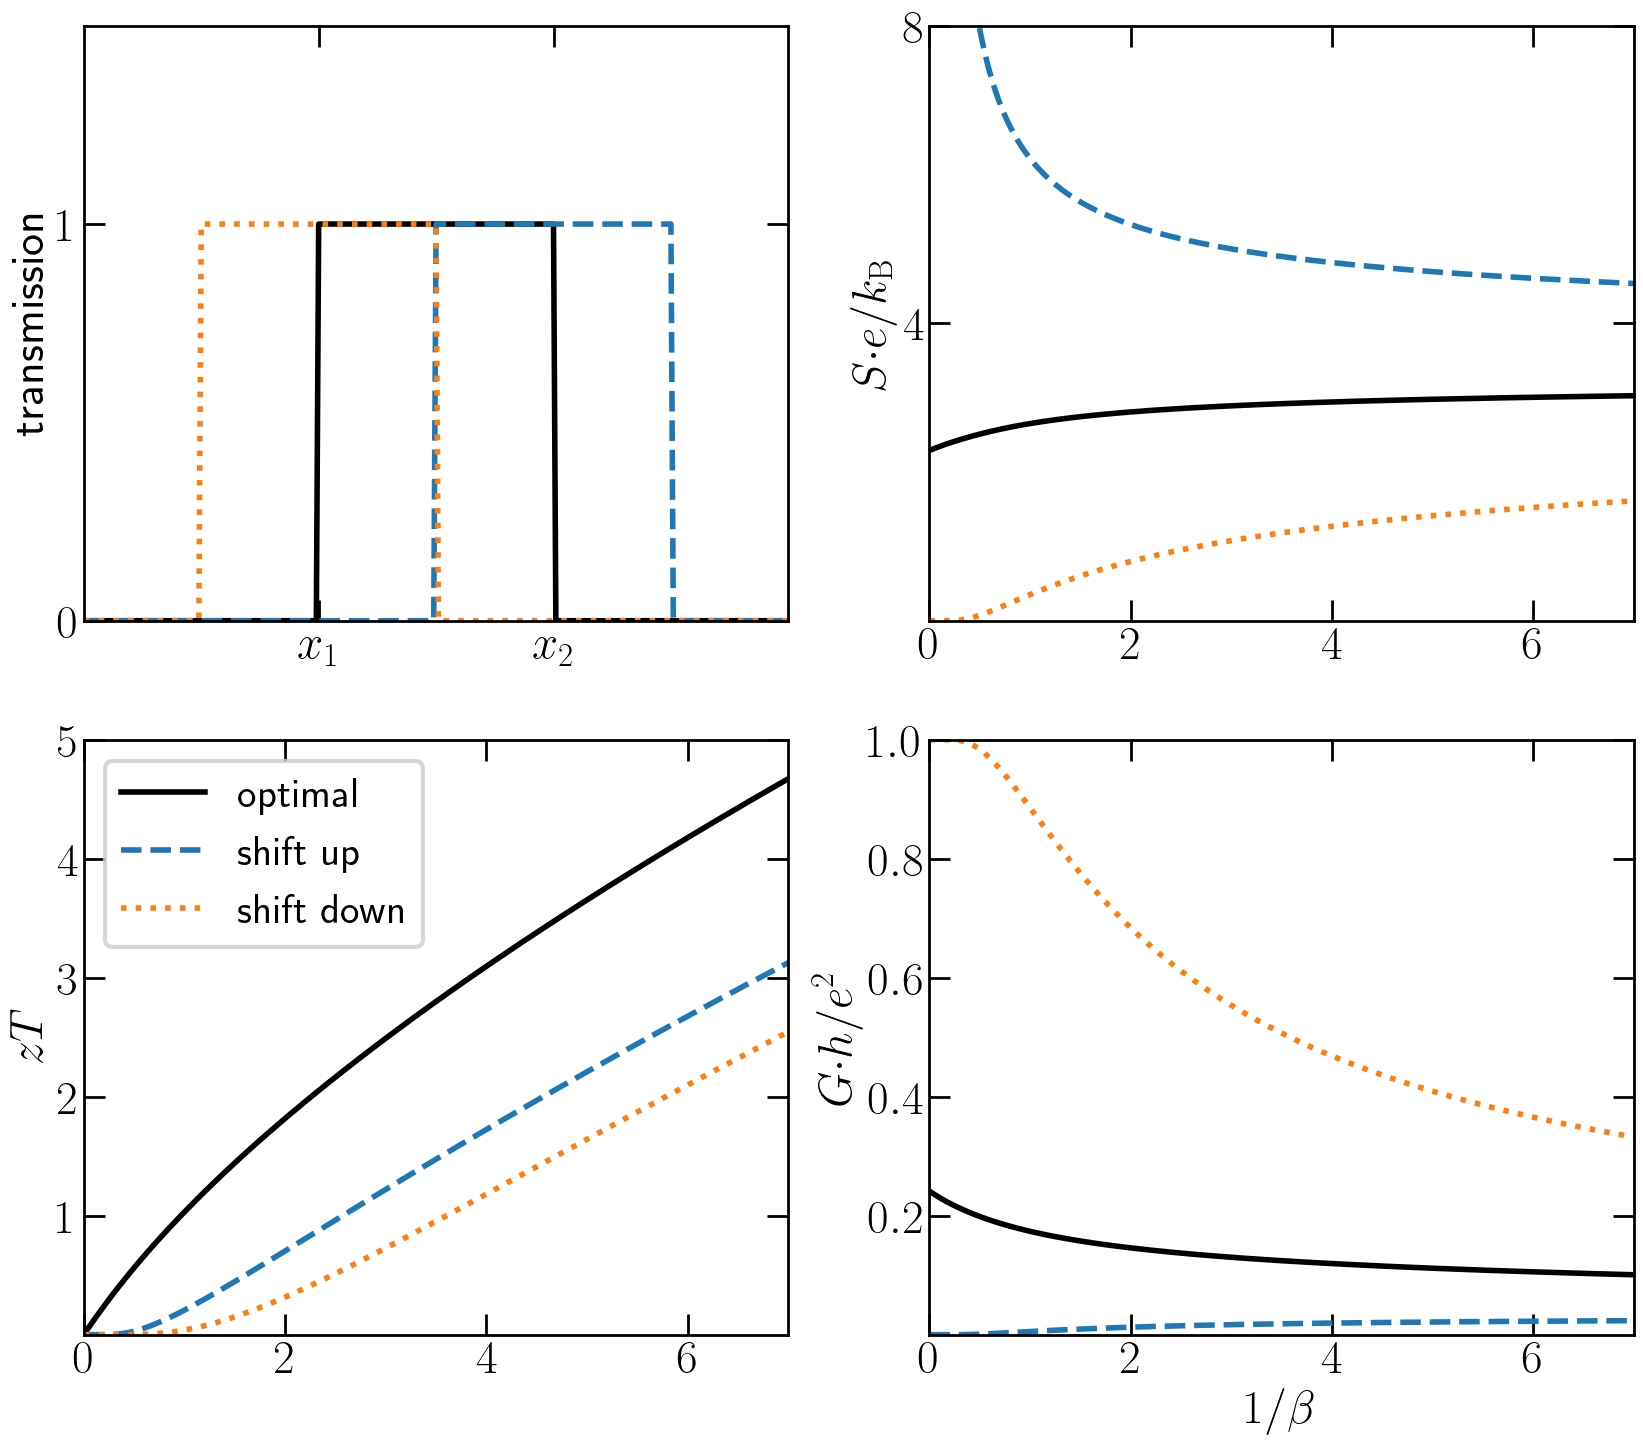

In [13]:
def plot_shift(axes=None):
    if axes is None:
        axes = plt.subplots(2,2, figsize=(20, 17))
    fig, ((ax0, ax1), (ax2,ax3)) = axes
    data_list = [
        opt_coeff,
        # data_trapezoid,
        data_shift_up,
        data_shift_down,
    ]
    label_list = [
        'optimal',
        # 'trapezoid',
        'shift up',
        'shift down',
    ]
    line_style_list = [
        'k-',
        '--',
        ':',
        '-.',
    ]
    x_range = np.linspace(-3, 3, 301)
    dom_y_list = [
        boxcar_dom(x_range, -1, 1),
        # trapezoid_dom(x_range, -1, 1),
        boxcar_dom(x_range, 0, 2),
        boxcar_dom(x_range, -2, 0),
    ]
    multi_plot(x_range, dom_y_list, label_list, line_style_list, (fig, ax0)) # data_opt[:,0]
    ax0.set_xticks([-1,1])
    ax0.set_xlim([-3,3])
    ax0.set_xticklabels([r"$x_1$", r"$x_2$"])
    ax0.set_ylim([0,1.5])
    ax0.set_yticks([0., 1.])
    ax0.set_ylabel('transmission')
    plot_coeff(data_list, label_list, line_style_list, axes=(fig, ax2))
    ax2.set_ylabel(r'$zT$')
    ax2.set_ylim([0,5])
    ax2.set_yticks([1, 2, 3, 4, 5])
    plot_coeff(data_list, label_list, line_style_list, coeff_type=1, axes=(fig, ax1))
    ax1.set_ylabel(r'$S{\cdot}e/k_\mathrm{B}$')
    ax1.set_ylim([0, 8])
    ax1.set_yticks([4, 8])
    plot_coeff(data_list, label_list, line_style_list, coeff_type=0, axes=(fig, ax3))
    ax3.set_ylabel(r'$G{\cdot}h/e^2$')
    ax3.set_ylim([0, 1])
    ax3.set_yticks([.2, .4, .6, .8, 1.])
    ax3.set_xlabel(r'$1/\beta$')
    ax2.set_xlim([0,7])
    ax1.set_xlim([0,7])
    ax3.set_xlim([0,7])
    ax0.legend('', frameon=False)
    ax1.legend('', frameon=False)
    ax3.legend('', frameon=False)
    ax2.legend(fontsize=30)
_ = plot_shift()

### plot broaden or narrow

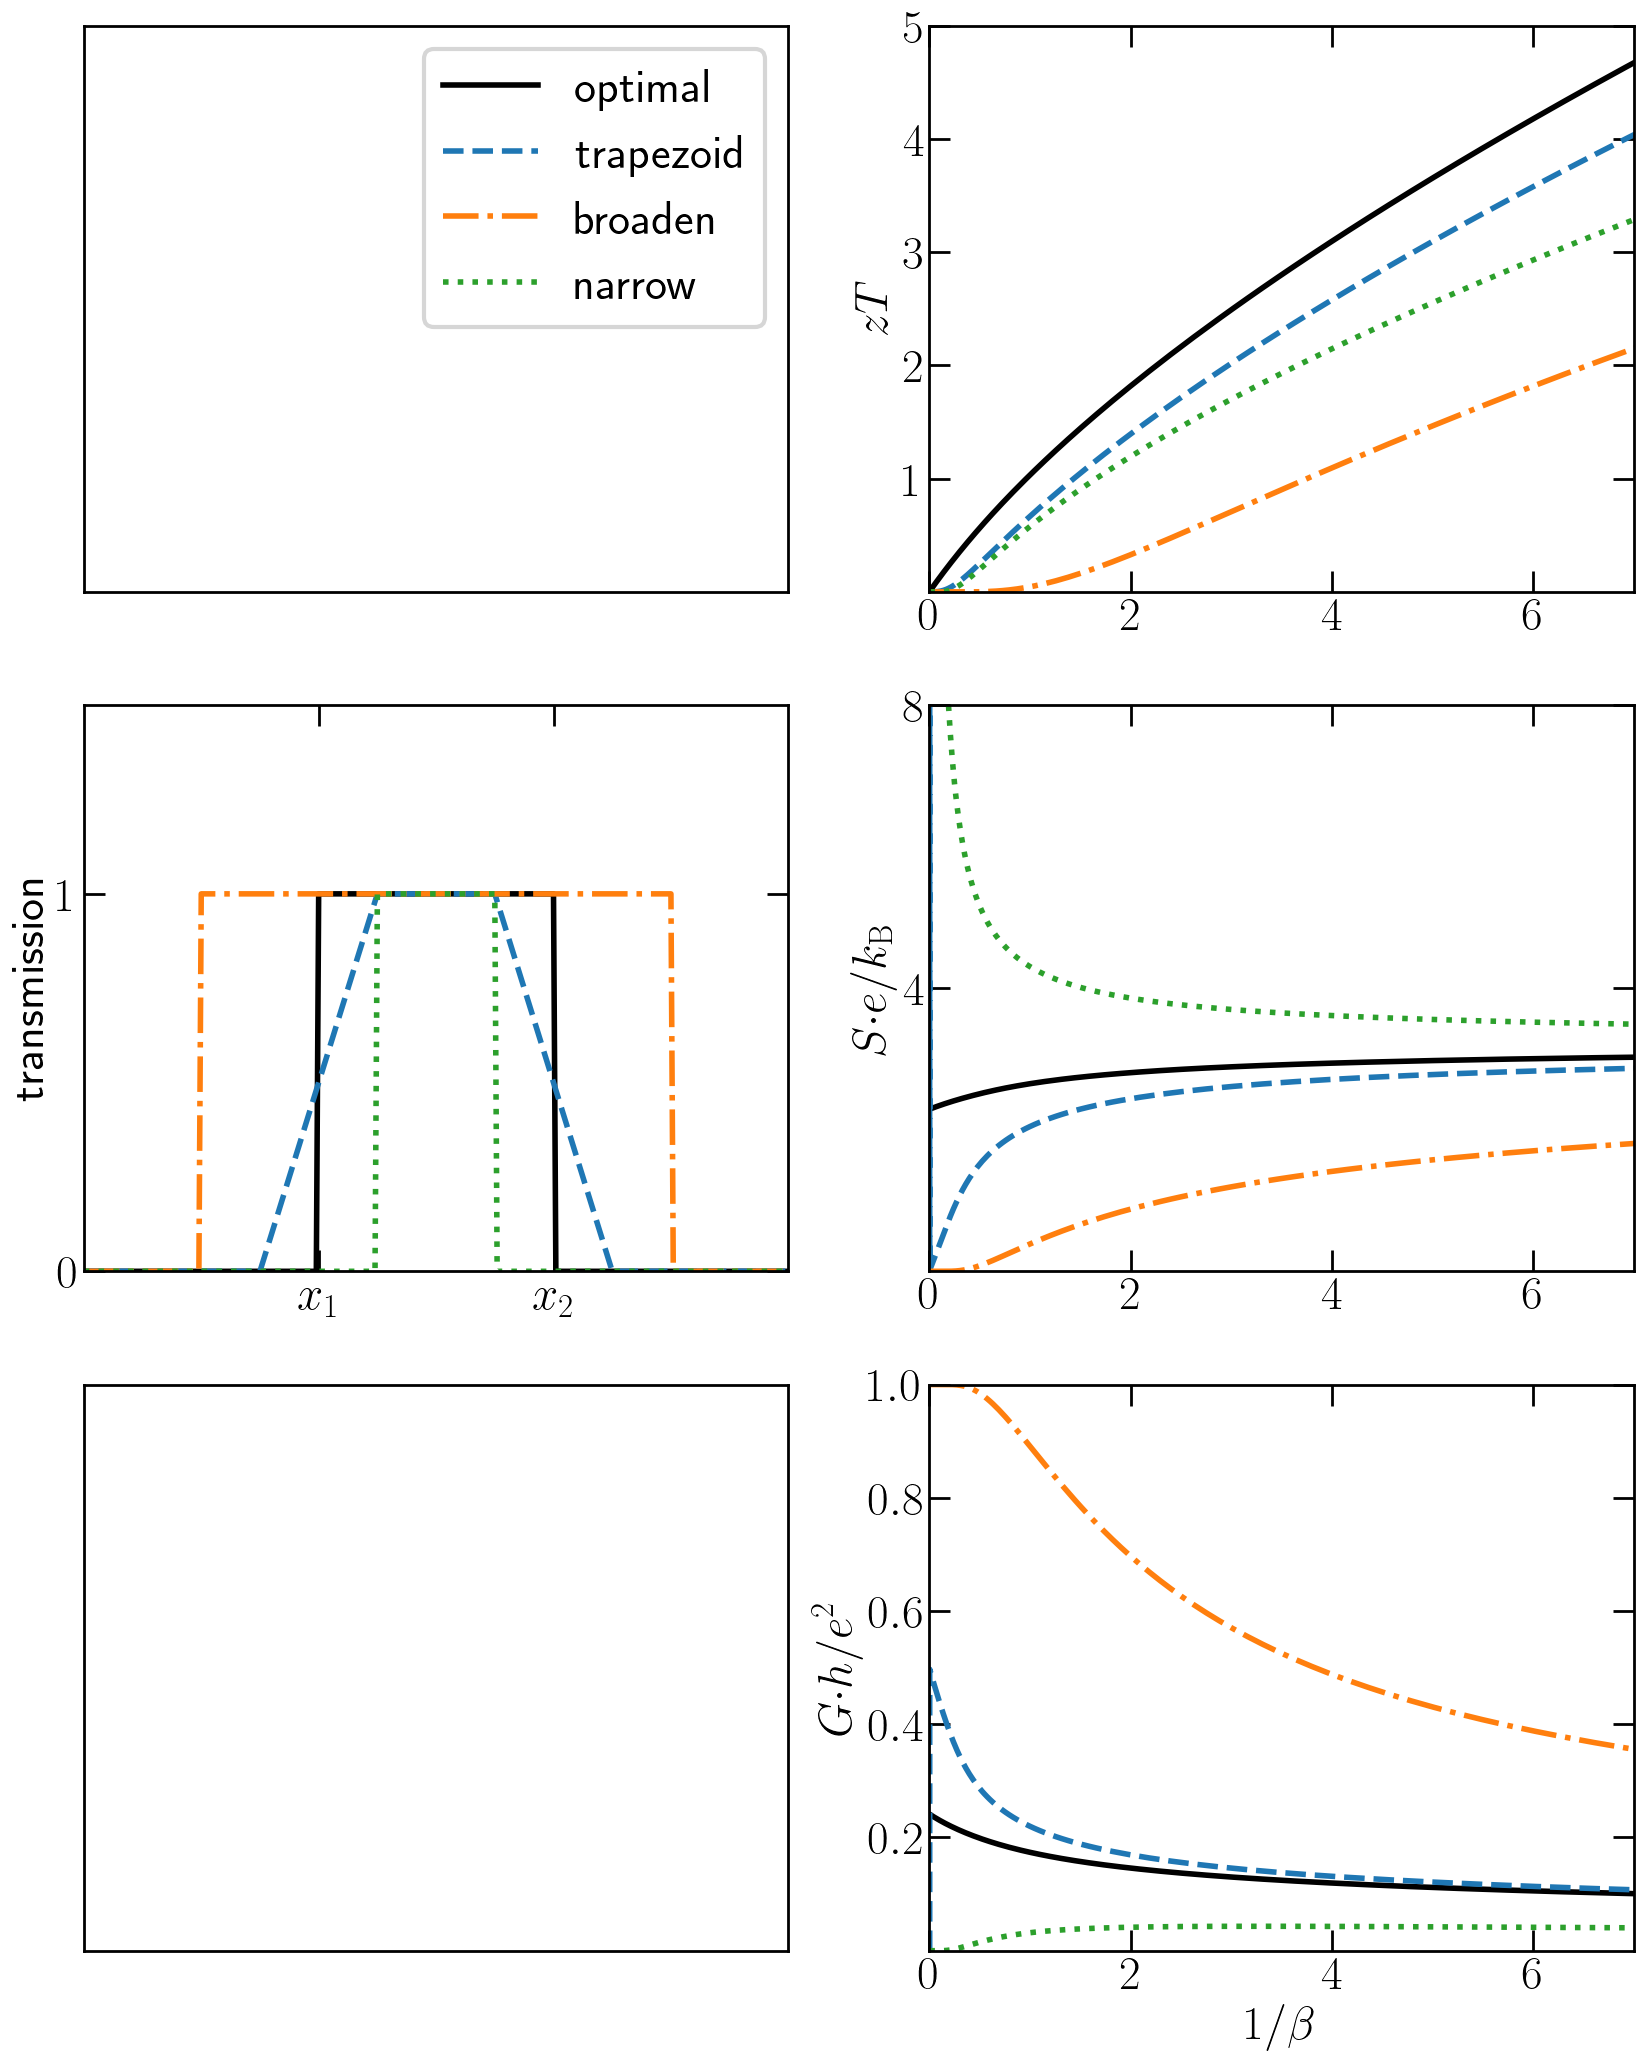

In [24]:
def plot_broaden_narrow(axes=None):
    if axes is None:
        axes = plt.subplots(3,2, figsize=(20, 25))
    fig, ((ax0, ax1), (ax2,ax3), (ax4,ax5)) = axes
    data_list = [
        opt_coeff,
        data_trapezoid,
        data_broaden,
        data_narrow,
    ]
    label_list = [
        'optimal',
        'trapezoid',
        'broaden',
        'narrow',
    ]
    line_style_list = [
        'k-',
        '--',
        '-.',
        ':',
    ]
    x_range = np.linspace(-3, 3, 301)
    dom_y_list = [
        boxcar_dom(x_range, -1, 1),
        trapezoid_dom(x_range, -1, 1),
        boxcar_dom(x_range, -2, 2),
        boxcar_dom(x_range, -.5, .5),
    ]
    multi_plot(x_range, dom_y_list, label_list, line_style_list, (fig, ax2)) # data_opt[:,0]
    ax2.set_xticks([-1,1])
    ax2.set_xlim([-3,3])
    ax2.set_xticklabels([r"$x_1$", r"$x_2$"])
    ax2.set_ylim([0,1.5])
    ax2.set_yticks([0., 1.])
    ax2.set_ylabel('transmission')
    plot_coeff(data_list, label_list, line_style_list, axes=(fig, ax1))
    ax1.set_ylabel(r'$zT$')
    ax1.set_ylim([0,5])
    ax1.set_yticks([1, 2, 3, 4, 5])
    plot_coeff(data_list, label_list, line_style_list, coeff_type=1, axes=(fig, ax3))
    ax3.set_ylabel(r'$S{\cdot}e/k_\mathrm{B}$')
    ax3.set_ylim([0, 8])
    ax3.set_yticks([4, 8])
    plot_coeff(data_list, label_list, line_style_list, coeff_type=0, axes=(fig, ax3))
    ax5.set_ylabel(r'$G{\cdot}h/e^2$')
    ax5.set_ylim([0, 1])
    ax5.set_yticks([.2, .4, .6, .8, 1.])
    ax5.set_xlabel(r'$1/\beta$')
    ax1.set_xlim([0,7])
    ax3.set_xlim([0,7])
    ax5.set_xlim([0,7])
    ax1.legend('', frameon=False)
    ax2.legend('', frameon=False)
    ax3.legend('', frameon=False)
    ax5.legend('', frameon=False)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax0.legend(handles=ax2.lines)
_ = plot_broaden_narrow()

## plot vs. Fermi level

In [1]:
from scipy import interpolate


ValueError: x and y arrays must be equal in length along interpolation axis.

In [22]:
def calc4Fermi():
    f = interpolate.interp1d(
        [4.051616644971972825,3.917214266520575361],
        [
            [5.754399373371566817,5.495408738576242236],
            [2.075066605996349622,2.061810370006153637],
            [5.401612902367745050,5.448825555420510725]
        ]
    )
    params = f(4)
    x0 = params[1:] - np.average(params[1:])
    fermi_range = np.linspace(0, 10, 201)[:,np.newaxis]
    x = x0 + fermi_range
    beta = 1 / params[0]
    print(beta, x0[1] - x0[0])
    results = []
    for x1, x2 in x:
        results.append(sigma_seebeck_zT(x1, x2, beta))
    return np.hstack([fermi_range, np.vstack(results)])
# calc4Fermi()

0.17683668738152938 3.3497691084491508


In [ ]:
data_Fermi = calc4Fermi()

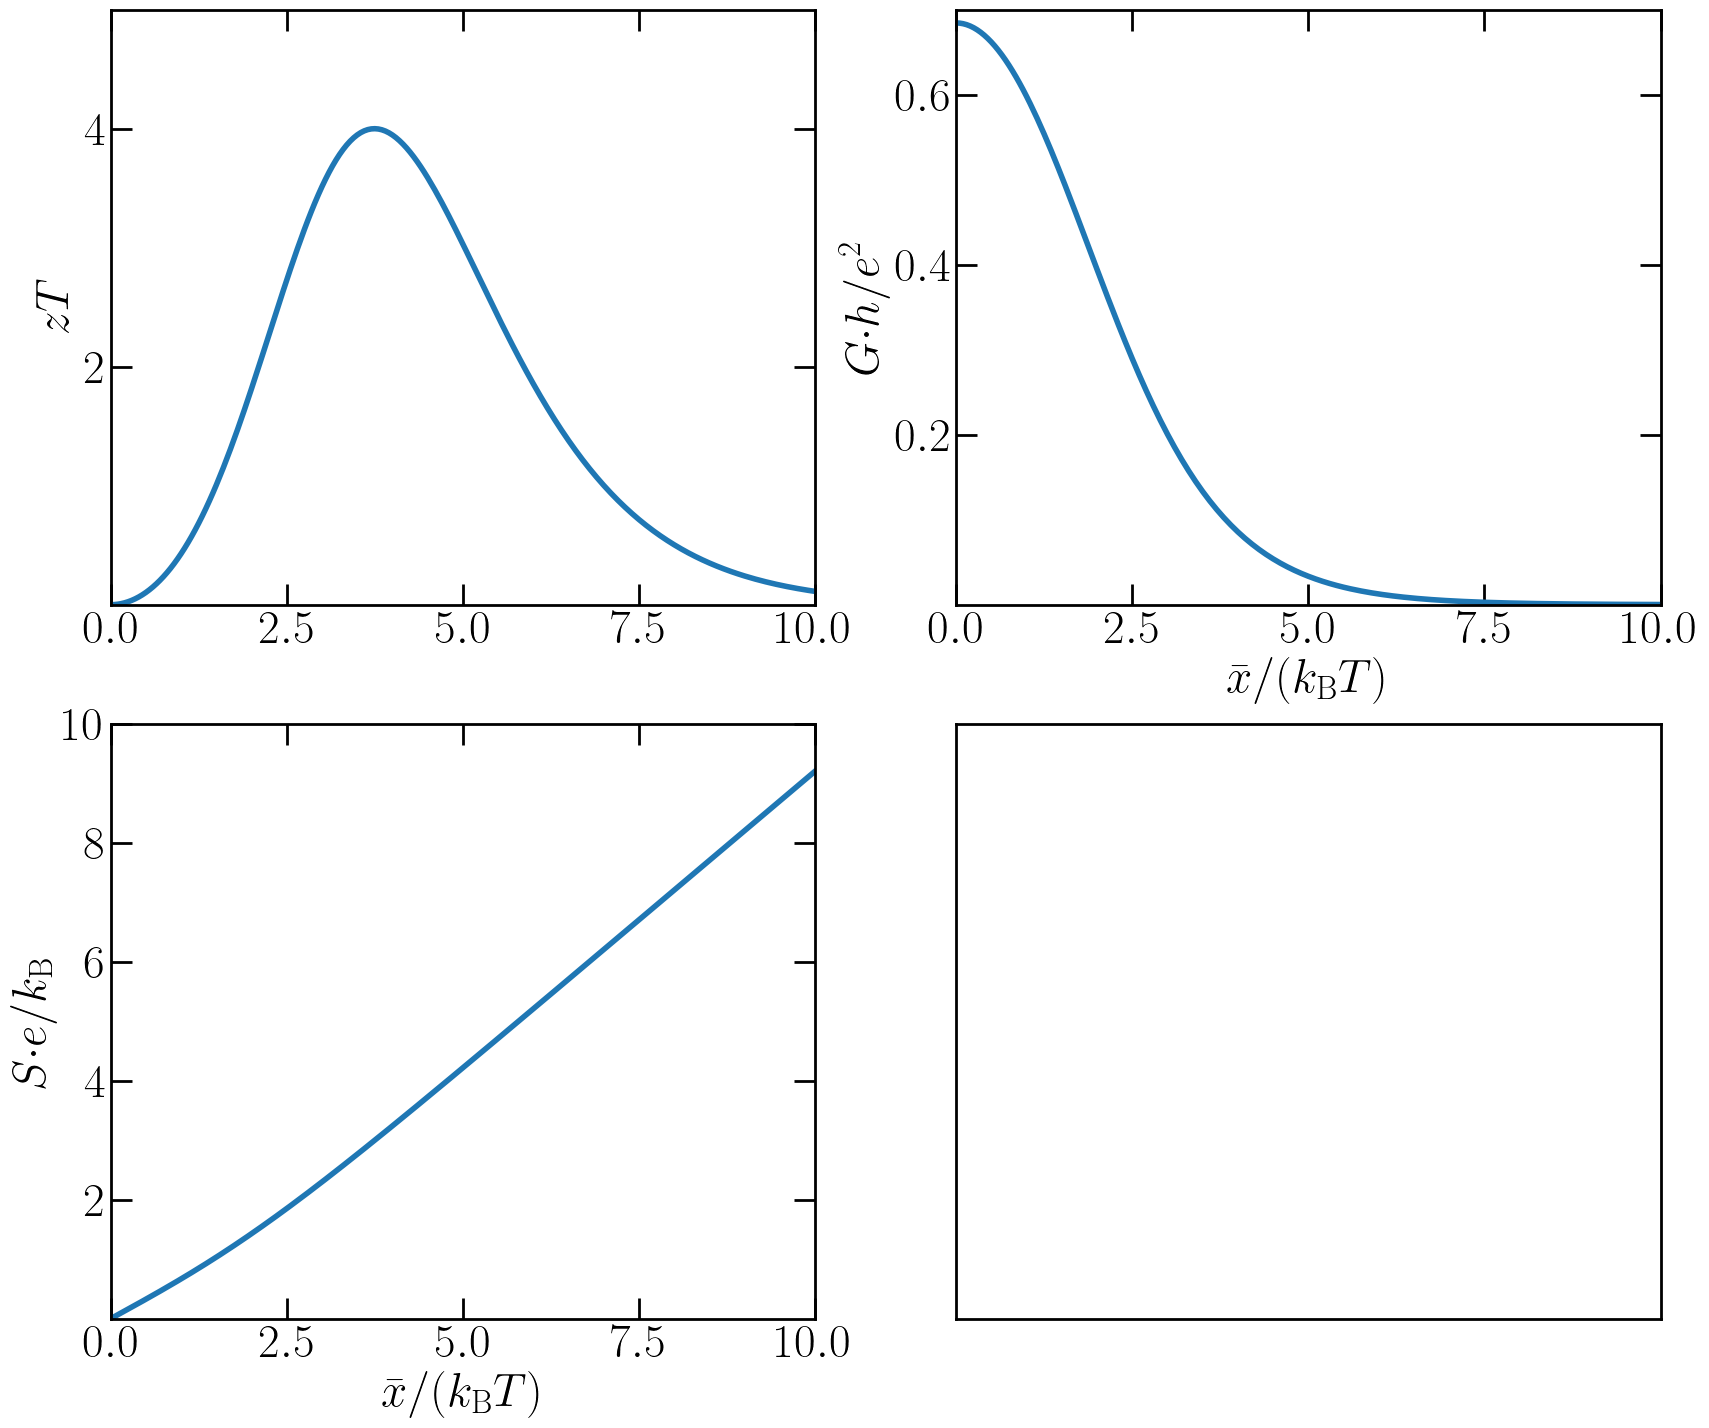

In [20]:
def plot_Fermi(axes=None):
    if axes is None:
        axes = plt.subplots(2,2, figsize=(20, 17))
    fig, ((ax0, ax1), (ax2,ax3)) = axes
    single_plot(data_Fermi[:,0], data_Fermi[:,3], (fig, ax0))
    ax0.set_xlim([0, 10])
    ax0.set_ylim([0, 5])
    ax0.set_yticks([2, 4])
    ax0.set_ylabel(r'$zT$')
    single_plot(data_Fermi[:,0], data_Fermi[:,1], (fig, ax1))
    ax1.set_xlim([0, 10])
    ax1.set_ylim([0, .7])
    ax1.set_yticks([.2, .4, .6])
    ax1.set_ylabel(r'$G{\cdot}h/e^2$')
    ax1.set_xlabel(r"$\bar{x}/(k_\mathrm{B}T)$")
    single_plot(data_Fermi[:,0], data_Fermi[:,2], (fig, ax2))
    ax2.set_xlim([0, 10])
    ax2.set_ylim([0, 10])
    ax2.set_yticks([2, 4, 6, 8, 10])
    ax2.set_ylabel(r'$S{\cdot}e/k_\mathrm{B}$')
    ax2.set_xlabel(r"$\bar{x}/(k_\mathrm{B}T)$")
    ax3.set_xticks([])
    ax3.set_yticks([])
    return axes
_ = plot_Fermi()